In [1]:
import os
import numpy as np
import cv2 as cv

In [2]:
classes = {'benign':0, 'malignant':1}

In [3]:
path = 'E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/datasets/Skin Cancer/'

In [4]:
images = []
labels = []

def load_data(path):
    
    for folders in os.listdir(path):
        for folder in os.listdir(path + folders + '/'):
            labels_act = folder
            for files in os.listdir(path + folders + '/' + folder + '/'):
                image = cv.imread(path + folders + '/' + folder + '/' + files)
                image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                image = cv.resize(image, (150, 150))
                image = image.astype('float32')/255.0
                label = labels_act
                label = classes[label]
                images.append(image)
                labels.append(label)
    
    images_r = np.array(images)
    labels_r = np.array(labels)
    
    return images_r, labels_r

In [5]:
images, labels = load_data(path)

In [6]:
images.shape, labels.shape

((3297, 150, 150, 3), (3297,))

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.1, random_state=10)

In [8]:
Y_train_req = to_categorical(Y_train)
Y_test_req = to_categorical(Y_test)

print(X_train.shape, X_test.shape, Y_train_req.shape, Y_test_req.shape)

(2967, 150, 150, 3) (330, 150, 150, 3) (2967, 2) (330, 2)


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmentor = ImageDataGenerator(rotation_range=20, width_shift_range=0.15, height_shift_range=0.15, shear_range=0.1, horizontal_flip=True, vertical_flip=True, validation_split=0.1)

train_batches = augmentor.flow(X_train, Y_train_req, shuffle=True, subset='training')
val_batches = augmentor.flow(X_test, Y_test_req, subset='validation')

In [10]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

In [11]:
def conv_layer(inputs, filters, stride):
    
    shortcut = inputs
    
    f1, f2, f3 = filters
    
    conv_a = Conv2D(f1, (1,1), strides=(stride,stride), kernel_initializer='glorot_uniform')(inputs)
    conv_a = BatchNormalization(axis=3)(conv_a)
    conv_a = Activation('relu')(conv_a)
    
    conv_b = Conv2D(f2, (3,3), strides=(1, 1), padding='same', kernel_initializer='glorot_uniform')(conv_a)
    conv_b = BatchNormalization(axis=3)(conv_b)
    conv_b = Activation('relu')(conv_b)
    
    conv_c = Conv2D(f3, (1,1), strides=(1,1), kernel_initializer='glorot_uniform')(conv_b)
    conv_c = BatchNormalization(axis=3)(conv_c)
    
    shortcut = Conv2D(f3, (1,1), strides=(stride, stride), kernel_initializer='glorot_uniform')(shortcut)
    shortcut = BatchNormalization(axis=3)(shortcut)
    
    output = Add()([conv_c, shortcut])
    output = Activation('relu')(output)
    
    return output

In [12]:
def identity_layer(inputs, filters):
    
    shortcut = inputs
    
    f1, f2, f3 = filters
    
    conv_a = Conv2D(f1, (1,1), strides=(1,1), kernel_initializer='glorot_uniform')(inputs)
    conv_a = BatchNormalization(axis=3)(conv_a)
    conv_a = Activation('relu')(conv_a)
    
    conv_b = Conv2D(f2, (3,3), strides=(1,1), padding='same', kernel_initializer='glorot_uniform')(conv_a)
    conv_b = BatchNormalization(axis=3)(conv_b)
    conv_b = Activation('relu')(conv_b)
    
    conv_c = Conv2D(f3, (1,1), strides=(1,1), kernel_initializer='glorot_uniform')(conv_b)
    conv_c = BatchNormalization(axis=3)(conv_c)
    
    output = Add()([conv_c, shortcut])
    output = Activation('relu')(output)
    
    return output

In [13]:
def ResNet50(input_shape, classes):
    
    inputs = Input(input_shape)
    
    zero_padding = ZeroPadding2D((3,3))(inputs)
    
    #### CONVOLUTION BLOCK 1
    conv_1 = Conv2D(64, (7,7), strides=(2,2))(zero_padding)
    conv_1 = BatchNormalization(axis=3)(conv_1)
    conv_1 = Activation('relu')(conv_1)
    conv_1 = ZeroPadding2D((1,1))(conv_1)
    conv_1 = MaxPooling2D((3,3), strides=(2,2))(conv_1)
    
    #### CONVOLUTIONAL BLOCK 2
    conv_2 = conv_layer(conv_1, [64, 64, 256], stride=1)
    conv_2 = identity_layer(conv_2, [64,64,256])
    conv_2 = identity_layer(conv_2, [64, 64, 256])
    
    #### CONVOLUTIONAL BLOCK 3
    conv_3 = conv_layer(conv_2, [128, 128, 512], stride=2)
    conv_3 = identity_layer(conv_3, [128, 128, 512])
    conv_3 = identity_layer(conv_3, [128, 128, 512])
    conv_3 = identity_layer(conv_3, [128, 128, 512])
    
    #### CONVOLUTIONAL BLOCK 4
    conv_4 = conv_layer(conv_3, [256, 256, 1024], stride=2)
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    conv_4 = identity_layer(conv_4, [256, 256, 1024])
    
    #### CONVOLUTIONAL BLOCK 5
    conv_5 = conv_layer(conv_4, [512, 512, 2048], stride=2)
    conv_5 = identity_layer(conv_5, [512, 512, 2048])
    conv_5 = identity_layer(conv_5, [512, 512, 2048])
   
    #### BASEMODEL TILL HERE
    
    #### HEAD MODEL FROM HERE - YOU CAN CHANGE THE HEAD MODEL AS YOU WISH
    
    #### AVERAGE POOLING
    avg_pooling = GlobalAveragePooling2D()(conv_5)
    
    output = Dense(512, activation='relu', kernel_initializer='glorot_uniform')(avg_pooling)
    output = BatchNormalization()(output)
    output = Dropout(0.25)(output)
    output = Dense(128, activation='relu', kernel_initializer='glorot_uniform')(output)
    output = BatchNormalization()(output)
    output = Dense(classes, activation='sigmoid')(output)
    
    model_resnet50 = Model(inputs=inputs, outputs=output)
    
    return model_resnet50

In [14]:
model = ResNet50(input_shape=(150, 150, 3), classes=2)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 75, 75, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 75, 75, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

model_save_path = 'E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/Saved Models/Skin Cancer/Skin Cancer.h5'

In [17]:
opt = Adam(lr=0.0001)
lr_call = ReduceLROnPlateau(verbose=1, min_lr=0.00001, monitor='val_accuracy', factor=0.7, patience=3)
model_monitor = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_accuracy')

In [18]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [19]:
steps = X_train.shape[0]/32
history = model.fit_generator(train_batches, epochs=50, steps_per_epoch=steps, validation_data=val_batches, callbacks=[lr_call, model_monitor])

Epoch 1/50
93/92 [==============================] - 87s 940ms/step - loss: 0.5107 - accuracy: 0.7481 - val_loss: 1.2398 - val_accuracy: 0.5758
Epoch 2/50
93/92 [==============================] - 94s 1s/step - loss: 0.4346 - accuracy: 0.7954 - val_loss: 0.5822 - val_accuracy: 0.5758
Epoch 3/50
93/92 [==============================] - 223s 2s/step - loss: 0.4307 - accuracy: 0.7881 - val_loss: 1.5472 - val_accuracy: 0.5758
Epoch 4/50
93/92 [==============================] - 473s 5s/step - loss: 0.4198 - accuracy: 0.7901 - val_loss: 1.4922 - val_accuracy: 0.6061
Epoch 5/50
93/92 [==============================] - 467s 5s/step - loss: 0.3912 - accuracy: 0.8118 - val_loss: 0.5169 - val_accuracy: 0.5758
Epoch 6/50
93/92 [==============================] - 473s 5s/step - loss: 0.3998 - accuracy: 0.8117 - val_loss: 0.2789 - val_accuracy: 0.7576
Epoch 7/50
93/92 [==============================] - 469s 5s/step - loss: 0.3988 - accuracy: 0.8091 - val_loss: 0.5434 - val_accuracy: 0.7879
Epoch 8/50
9

In [20]:
import matplotlib.pyplot as plt

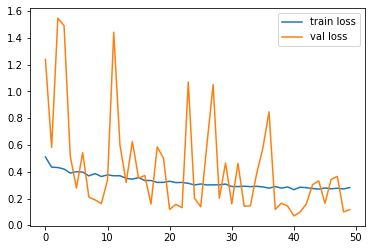

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.show()

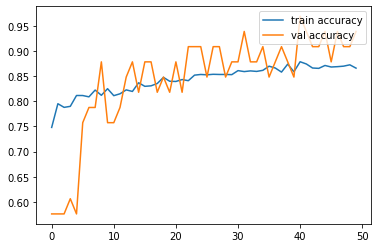

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train accuracy', 'val accuracy'], loc='upper right')
plt.show()

In [25]:
from tensorflow.keras.models import load_model

model_req = load_model('E:/NMIMS_Semester III/Image Proceesing - ANN, CNN/Saved Models/Skin Cancer/Skin Cancer.h5')

In [28]:
predictions = model_req.evaluate(X_test, Y_test_req)

330/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================